## Homework: Simple Spread Trading

========================================================================================================================

### Richmond Frankeberger 12277572 

========================================================================================================================

### Defining Data

Based on the assignment, the last digit of the student ID will define which ETF pair to analyze. The below will apply for this worksheet.

2: PXJ OIH

PXJ is the Invesco Dynamic Oil & Gas Services ETF. It has net assets of approx USD 20mn, and invests in oil-related mid-cap and small-cap equities.

OIH is the VanEck Vectors Oil Services ETF. Its net assets are much larger at approx USD 2bn, and invests in mostly oil-related large-caps and mid-caps.

========================================================================================================================

#### Imports and Functions 

In [270]:
%matplotlib inline
from   matplotlib                import pyplot as plt
from   statsmodels.tsa.stattools import adfuller
from   statsmodels.tsa.seasonal  import seasonal_decompose
import pandas                    as     pd
import plotnine                  as     p9
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
import quandl
import scipy
import sys

In [2]:
### Download and format Fama French data. Data is available only up to November of last year.
FFFactors         = pd.read_csv(r"D:\Documents\Education\University of Chicago\Q2\Regression Analysis\HW\HW2_Fama_French_Factors.csv")
FFFactors['Date'] = pd.to_datetime(FFFactors['Date'], format='%Y%m%d', errors='ignore')
FFFactors         = FFFactors.set_index('Date')
FFFactors         = FFFactors.loc['2019-12-02':'2021-11-30']

In [3]:
### Use to download data from Quandl.
### Arguments: symbol: Enter database code and symbol code here. start and end refer to dates (YYYY-MM-DD)
def quandler_table(symbol_arr,start,end):
    data = quandl.get_table("QUOTEMEDIA/PRICES", api_key = "hJrpPb7hMqbAvC9tkQZy", qopts = { 'columns': ['ticker', 'date', 'adj_close', 'adj_volume'] }, ticker = symbol_arr, date = { 'gte': start, 'lte': end })
    return data

In [4]:
### Provides basic statistics for a given dataset.
### Arguments: data: pass a dataframe q: level of significance for VaR/Shortfall
def statistics(data, q):
    df                                        = data.copy()
    df.index                                  = data.index.date
    report                                    = pd.DataFrame(columns = df.columns)
    report.loc['Mean']                        = df.mean()
    report.loc['Median']                      = df.median()
    report.loc['Min']                         = df.min()
    report.loc['25% Quantile']                = df.quantile(0.25)
    report.loc['75% Quantile']                = df.quantile(0.75)
    report.loc['Max']                         = df.max()
    report.loc[r'$\sigma$']                   = df.std()
    report.loc['Skewness']                    = df.skew()
    report.loc['Excess Kurtosis']             = df.kurtosis()
    report.loc['VaR (Quantile {})'.format(q)] = df.quantile(q)
    report.loc['VaR (Normal)']                = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']          = df[df     < df.quantile(q)].mean()
    report.loc['Expected Shortfall (Normal)'] = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    return round(report,4)

In [5]:
### Use to graph the spread and entry/exit points per month for a given strategy.
def graph_spreads(data_spread, M, g, j):
    fig, ax1 = plt.subplots(figsize=(15,10))
    ax1.plot(data_spread.index       , data_spread['M_Day_Ret'],'cornflowerblue')
    plt.axhspan(g,   j, color='grey' , alpha=0.3)
    plt.axhspan(-g, -j, color='grey' , alpha=0.3)
    plt.axhline(y=g,    color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=-g,   color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=j,    color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=-j,   color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=data_spread['M_Day_Ret'].mean()   , color='black', linestyle='--',linewidth=1)
    fig.suptitle('{}-Day Returns Pre-Monthend Entry and Exit Points for PXJ-OIH Spreads'.format(M))
    for i in data_spread[data_spread['First'] == True].index:
        plt.axvline(x=i,color='black', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('{}-Day Returns'.format(M))
    plt.scatter(data_spread[(data_spread['Mark'] == 'Sell')]['M_Day_Ret'].index, data_spread[(data_spread['Mark'] == 'Sell')]['M_Day_Ret'], color='red',   marker='v', alpha=1)
    plt.scatter(data_spread[(data_spread['Mark'] == 'Buy')]['M_Day_Ret'].index,  data_spread[(data_spread['Mark'] == 'Buy')]['M_Day_Ret'],  color='green', marker='^', alpha=1)
    plt.show()

In [134]:
### Use for running simulations on the spread strategy
def simulate(data, spread, M, g, j, s):
    data = spread_strat(data, spread, M, g, j, s, False)
    return data['PL_LTD'][-1]

In [235]:
### Use to calculate Skewness, Excess Kurtosis, VaR(q), CVaR(q), MMD, MMD Start, MMD End, MMD Recovery
### Don't need to annualize
def tail_risk_report(data, q, returns=True):
    df                                           = data.copy()
    df.index                                     = data.index.date
    report                                       = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness']                       = df.skew()
    report.loc['Excess Kurtosis']                = df.kurtosis()
    report.loc['VaR (Quantile {})'.format(q)]    = df.quantile(q)
    report.loc['VaR (Normal)']                   = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']             = df[df < df.quantile(q)].mean()
    report.loc['Expected Shortfall (Normal)']    = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    if returns == True:
        cum_ret                                  = (1 + df).cumprod()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max) / rolling_max
    else:
        cum_ret                                  = df.cumsum()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max)
         
    report.loc['Max Drawdown']                   = drawdown.min()
    report.loc['MDD Start']                      = None
    report.loc['MDD End']                        = drawdown.idxmin()
    report.loc['Recovery Date']                  = None
    report.loc['Single Largest Drawdown']        = df.min()
    report.loc['Single Largest Drawdown Date']   = df.idxmin()
    
    for col in df.columns:
        report.loc['MDD Start', col]             = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df                              = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col]     = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col]     = None
            report.loc['Recovery period (days)'] = None
    return round(report,4)

In [278]:
### Run OLS regressions and report data in annualized terms

def OLSIntercept(y,x):
    myx = sm.add_constant(x)
    OLS = sm.OLS(y,myx,missing='drop').fit()
    TE  = OLS.resid.std() * np.sqrt(252)
    return ('Beta:',(OLS.params[1:])),('Alpha (Ann): {:.5f} R-Squared: {:.5f} Tracking Error: {:.5f}'.format(OLS.params['const']*252,OLS.rsquared,TE))

def OLSNOIntercept(y,x):
    myx = x
    OLS = sm.OLS(y,myx,missing='drop').fit()
    TE  = OLS.resid.std() * np.sqrt(252)
    return ('Beta:',(OLS.params[:])),('R-Squared: {:.5f} Tracking Error: {:.5f}'.format(OLS.rsquared,TE))

========================================================================================================================

#### Data Download and Wrangling

In [7]:
data    = quandler_table(['PXJ', 'OIH'],"2019-12-02","2021-12-31")

In [8]:
data    = data.set_index("date")

In [9]:
data    = data.assign(dollar_volume_k = data['adj_close'] * data['adj_volume'] / 1000)
data_Px = data.copy()
data_Px = data.pivot_table(index = 'date', columns = 'ticker', values = 'adj_close')

Considering the fact that the average $N_t$ is only about $300k, and our strategy is trading only a hundredth of the volume per stock, we can expect to have low absolute PL over the course of the analysis. It should not be surprising that this strategy will yield low return on capital figures later in the analysis as well.

I will also reorganize the dataframe in a way that makes it easy to apply a spread strategy on - in particular, it is good to line up the prices of X and Y, define what $N_t$ is, and also record the initial capital.

In [10]:
data_Nt  = data.pivot_table(index = 'date', columns = 'ticker', values = 'dollar_volume_k', aggfunc = 'sum')
data_Nt  = data_Nt.assign(min_dollar_vol = data_Nt[['PXJ','OIH']].min(axis=1))
data_Nt  = data_Nt.assign(N_t = data_Nt['min_dollar_vol'].shift().rolling(15).median() * 1000)
data_agg = pd.concat([data_Px, data_Nt['N_t']],axis = 1)
data_agg = data_agg.assign(Capital = data_agg['N_t'].max() * 2)
myspread = ['PXJ','OIH']
data_agg.head()

,OIH,PXJ,N_t,Capital
date,,,,
2019-12-02,224.947342,4.331013,NaN,5.212136e+06
2019-12-03,219.199114,4.240651,NaN,5.212136e+06
2019-12-04,228.779494,4.394906,NaN,5.212136e+06
2019-12-05,226.863418,4.368893,NaN,5.212136e+06
2019-12-06,236.443799,4.545967,NaN,5.212136e+06


#### Exercise: Strategy Implementation

Below is written a single function to implement a spread strategy that records its performance. Inputs include a dataframe and parameters given in the assignment: M, j, g, and s. Detailed comments are in line.

In [115]:
### Arguments: data = spread data from Quandl, M = return period, g = entry point, j = exit point, s = stop loss parameter (percentage)
def spread_strat(data, spread, M, g, j, s, printer=True):
    data_agg = data.reset_index()
    data_agg = data_agg.assign(Spread    = np.log(data_agg[spread[0]]/data_agg.shift()[spread[0]]) - np.log(data_agg[spread[1]]/data_agg.shift()[spread[1]]))
    data_agg = data_agg.assign(First     = np.where((data_agg['date'].dt.month < data_agg.shift()['date'].dt.month) & (data_agg['date'].dt.month == 1) | (data_agg.shift()['date'].dt.month < data_agg['date'].dt.month),True, False))
    data_agg = data_agg.assign(Last      = np.where((data_agg['date'].dt.month > data_agg.shift(-1)['date'].dt.month) & (data_agg.shift(-1)['date'].dt.month == 1) | (data_agg.shift(-1)['date'].dt.month > data_agg['date'].dt.month),True, False))
    data_agg = data_agg.assign(M_Day_Ret = np.log(data_agg[spread[0]]/data_agg.shift(M)[spread[0]]) - np.log(data_agg[spread[1]]/data_agg.shift(M)[spread[1]]))
    data_agg = data_agg.assign(Signal    = np.where( ((abs(data_agg['M_Day_Ret']) > g) & (data_agg['M_Day_Ret'] < 0) ) , "Buy" , np.where((abs(data_agg['M_Day_Ret']) > g) & (data_agg['M_Day_Ret'] > 0), "Sell", np.where(abs(data_agg['M_Day_Ret']) < j, "Exit", "Hold"))   ))
    data_agg = data_agg.assign(Position  = 0, X_Shares = 0, Y_Shares = 0, X_MV = 0, Y_MV = 0, GTCash = 0, StopLossLevel = 0, OpenGrossMV = 0, StopLossTrigger = 'No', PL_DLY = 0, PL_LTD = 0, NetAssets = data_agg['Capital'][0], Mark = 'No', StopLossDay = 'No')
    
    data_agg = data_agg.set_index('date')
    start    = data_agg.index[0]
    counter  = data_agg.index[0]
    for i in data_agg.index:
        
        ### StopLossTrigger Check: If the Stop Loss was triggered, do not do anything for the rest of the month
        if (data_agg.loc[counter,'StopLossTrigger'] == 'Yes') & (data_agg.loc[i,'Last'] != True):
            data_agg.loc[i,'StopLossTrigger'] = 'Yes'
            continue
        
        ### Position: Store the position that should be held given the signal.
        
        ##  control for the first month
        if data_agg.loc[start:i,'First'].sum() < 1:
            continue
        ##  exit position if the last day of the month
        if data_agg.loc[i,'Last']      == True:
            data_agg.loc[i,'Position'] = 0
        ##  loop through the rest of the dataset
        elif data_agg.loc[i,'Signal']  == 'Sell':
            data_agg.loc[i,'Position'] = -1
        elif data_agg.loc[i,'Signal']  == 'Buy':
            data_agg.loc[i,'Position'] = 1
        elif data_agg.loc[i,'Signal']  == 'Exit':
            data_agg.loc[i,'Position'] = 0
        elif data_agg.loc[i,'Signal']  == 'Hold':
            data_agg.loc[i,'Position'] = data_agg.loc[counter,'Position']
        
        
        ### Balance: Balance represents the dollars invested at any given date.
        
        ##  Buy/Sell as many shares as possible when the Signal/Position indicates a switch/entry/exit. Also indicate the shares to hold per symbol.
        if ((data_agg.loc[i,'Position']   == -1) & (data_agg.loc[counter,'Position'] != -1)):
            data_agg.loc[i,'X_Shares']    = np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[0]])
            data_agg.loc[i,'Y_Shares']    = np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[1]])
            data_agg.loc[i,'X_MV']        = data_agg.loc[i,'X_Shares'] * data_agg.loc[i,spread[0]]
            data_agg.loc[i,'Y_MV']        = data_agg.loc[i,'Y_Shares'] * data_agg.loc[i,spread[1]]
            data_agg.loc[i,'GTCash']      = np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[0]]) * data_agg.loc[i,spread[0]] + np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[1]]) * data_agg.loc[i,spread[1]]
            data_agg.loc[i,'Mark']        = 'Sell'
        elif ((data_agg.loc[i,'Position'] == 1) & (data_agg.loc[counter,'Position'] != 1)): 
            data_agg.loc[i,'X_Shares']    = np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[0]])
            data_agg.loc[i,'Y_Shares']    = np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[1]])
            data_agg.loc[i,'X_MV']        = data_agg.loc[i,'X_Shares'] * data_agg.loc[i,spread[0]]
            data_agg.loc[i,'Y_MV']        = data_agg.loc[i,'Y_Shares'] * data_agg.loc[i,spread[1]]
            data_agg.loc[i,'GTCash']      = np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[0]]) * data_agg.loc[i,spread[0]] + np.round(data_agg.loc[i,'N_t'] / 100 / data_agg.loc[i,spread[1]]) * data_agg.loc[i,spread[1]]
            data_agg.loc[i,'Mark'] = 'Buy'
        elif (data_agg.loc[i,'Position']  == data_agg.loc[counter,'Position']):
            data_agg.loc[i,'X_Shares']    = data_agg.loc[counter,'X_Shares']
            data_agg.loc[i,'Y_Shares']    = data_agg.loc[counter,'Y_Shares']
            data_agg.loc[i,'X_MV']        = data_agg.loc[i,'X_Shares'] * data_agg.loc[i,spread[0]]
            data_agg.loc[i,'Y_MV']        = data_agg.loc[i,'Y_Shares'] * data_agg.loc[i,spread[1]]
            data_agg.loc[i,'GTCash']      = data_agg.loc[counter,'GTCash']
        elif (data_agg.loc[i,'Position']  == 0) & (data_agg.loc[counter,'Position'] == 1) & (data_agg.loc[i,'Signal'] == 'Exit'):
            data_agg.loc[i,'Mark']        = "Sell"
        elif (data_agg.loc[i,'Position']  == 0) & (data_agg.loc[counter,'Position'] == -1) & (data_agg.loc[i,'Signal'] == 'Exit'):
            data_agg.loc[i,'Mark']        = "Buy"
            
        ### StopLoss: Calculate the StopLoss level for a given day.
        
        data_agg.loc[i,'StopLossLevel']   = data_agg.loc[i,'GTCash'] * s
        
        ### OpenGrossMV: Calculate the Gross MV of the position - used to compare vs StopLoss
        
        data_agg.loc[i,'OpenGrossMV']     = data_agg.loc[i,'X_Shares'] * data_agg.loc[i,spread[0]] + data_agg.loc[i,'Y_Shares'] * data_agg.loc[i,spread[1]]
        
        ### PL_DLY: Calculate Daily PL
        
        if (data_agg.loc[i,'Position']    == -1) & (data_agg.loc[counter,'Position'] == -1) | (data_agg.loc[i,'Position'] == 1) & (data_agg.loc[counter,'Position'] == -1):
            data_agg.loc[i,'PL_DLY']      = ((data_agg.loc[i,'X_MV'] - data_agg.loc[counter,'X_MV']) - (data_agg.loc[i,'Y_MV'] - data_agg.loc[counter,'Y_MV'])) * -1
        elif (data_agg.loc[i,'Position']  == 1) & (data_agg.loc[counter,'Position'] == 1) | (data_agg.loc[i,'Position'] == -1) & (data_agg.loc[counter,'Position'] == 1):
            data_agg.loc[i,'PL_DLY']      = ((data_agg.loc[i,'X_MV'] - data_agg.loc[counter,'X_MV']) - (data_agg.loc[i,'Y_MV'] - data_agg.loc[counter,'Y_MV']))
        elif (data_agg.loc[i,'Position']  == 0) & (data_agg.loc[counter,'Position'] == 1):
            data_agg.loc[i,'PL_DLY']      = (((data_agg.loc[i,spread[0]] * data_agg.loc[counter,'X_Shares']) - data_agg.loc[counter,'X_MV']) - ((data_agg.loc[i,spread[1]] * data_agg.loc[counter,'Y_Shares']) - data_agg.loc[counter,'Y_MV']))
        elif (data_agg.loc[i,'Position']  == 0) & (data_agg.loc[counter,'Position'] == -1):
            data_agg.loc[i,'PL_DLY']      = (((data_agg.loc[i,spread[0]] * data_agg.loc[counter,'X_Shares']) - data_agg.loc[counter,'X_MV']) - ((data_agg.loc[i,spread[1]] * data_agg.loc[counter,'Y_Shares']) - data_agg.loc[counter,'Y_MV'])) * -1
        
        data_agg.loc[i,'NetAssets']       = data_agg.loc[counter,'NetAssets'] + data_agg.loc[i,'PL_DLY']
        
        ### Stop Loss Implementation: If a Stop Loss is triggered, reset the position.
        if (data_agg.loc[counter,'StopLossLevel'] > data_agg.loc[i,'OpenGrossMV']) & (data_agg.loc[i,'OpenGrossMV'] > 0):
            data_agg.loc[i,'StopLossTrigger'] = 'Yes'
            data_agg.loc[i,'StopLossDay']     = 'Yes'
        
        counter = i
    
    ### PL_LTD: Calculate cumulative PL
    
    data_agg['PL_LTD']      = data_agg['PL_DLY'].cumsum()
    data_agg['Returns_DLY'] = np.log((data_agg['NetAssets'] + data_agg['PL_DLY']) / data_agg['NetAssets'] )
    data_agg['Returns_LTD'] = np.log((data_agg['NetAssets'] + data_agg['PL_LTD']) / data_agg['NetAssets'] )
    
    if printer == True:
        print("Cumulative PL for the strategy was ${:.2f}, or {:.4f}%".format(data_agg['PL_LTD'][-1],data_agg['Returns_LTD'][-1]))
    
    return data_agg

Sample Output:

An example of a section of the output dataframe follows where a 5-day median return with entry = g (short) at 150bps and exit = j (buy) at 100bps in either direction is simulated, with a stop loss of 95% of Gross Traded Cash.

In [109]:
data_spread = spread_strat(data_agg,myspread,5,0.015,0.01,0.95)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_spread

Cumulative PL for the strategy was $185.82, or 0.0000%


,OIH,PXJ,N_t,Capital,Spread,First,Last,M_Day_Ret,Signal,Position,X_Shares,Y_Shares,X_MV,Y_MV,GTCash,StopLossLevel,OpenGrossMV,StopLossTrigger,PL_DLY,PL_LTD,NetAssets,Mark,StopLossDay,Returns_DLY,Returns_LTD
date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-02,224.9473,4.3310,NaN,"5,212,135.6155",NaN,False,False,NaN,Hold,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-03,219.1991,4.2407,NaN,"5,212,135.6155",0.0048,False,False,NaN,Hold,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-04,228.7795,4.3949,NaN,"5,212,135.6155",-0.0070,False,False,NaN,Hold,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-05,226.8634,4.3689,NaN,"5,212,135.6155",0.0025,False,False,NaN,Hold,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-06,236.4438,4.5460,NaN,"5,212,135.6155",-0.0016,False,False,NaN,Hold,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-09,236.6354,4.5820,NaN,"5,212,135.6155",0.0071,False,False,0.0057,Exit,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-10,237.2102,4.5943,NaN,"5,212,135.6155",0.0003,False,False,0.0011,Exit,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-11,241.4256,4.6239,NaN,"5,212,135.6155",-0.0112,False,False,-0.0030,Exit,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000
2019-12-12,249.0899,4.7475,NaN,"5,212,135.6155",-0.0049,False,False,-0.0104,Hold,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No,0.0000,0.0000,"5,212,135.6155",No,No,0.0000,0.0000


========================================================================================================================

#### Analysis

##### Example Cases

Below are highlighted some notable trading strategies on X and Y.

A graph showing the intramonth entry and exit points of the strategy is followed by daily dollar and percentage return statistics, per example.

The graph highlights entrance of a tightener in red and a widener in green. The grey bands are where we do not trade. The trades highlighted in between the grey bands are where open positions were exited to flatten out exposure.

##### 1. $M=5 \, , g=1.5\% \, , j=1.0\% \, , s = 95\%$

Cumulative PL for the strategy was $185.82, or 0.0000%


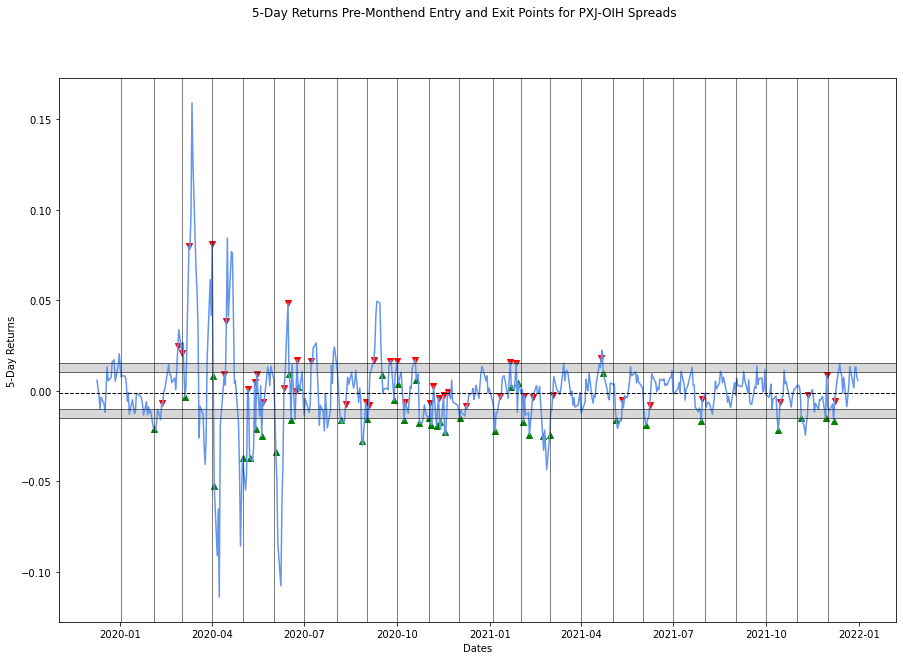

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
PL_DLY,0.3533,0.0000,-35.5101,0.0000,0.0000,58.5254,6.6882,2.7424,27.8128,-3.6628,-10.6478,-14.1485,-13.4425
M_Day_Ret,-0.0011,-0.0011,-0.1141,-0.0103,0.0068,0.1589,0.0223,0.9250,12.0951,-0.0270,-0.0377,-0.0529,-0.0470


In [110]:
data_spread = spread_strat(data_agg,myspread,5,0.015,0.01,0.95)
graph_spreads(data_spread, 5, 0.015,0.01)
statistics(data_spread[['PL_DLY','M_Day_Ret']],0.05).T

##### 2. $M=10 \, , g=1\% \, , j=0.5\% \, , s = 80\%$

Cumulative PL for the strategy was $464.03, or 0.0001%


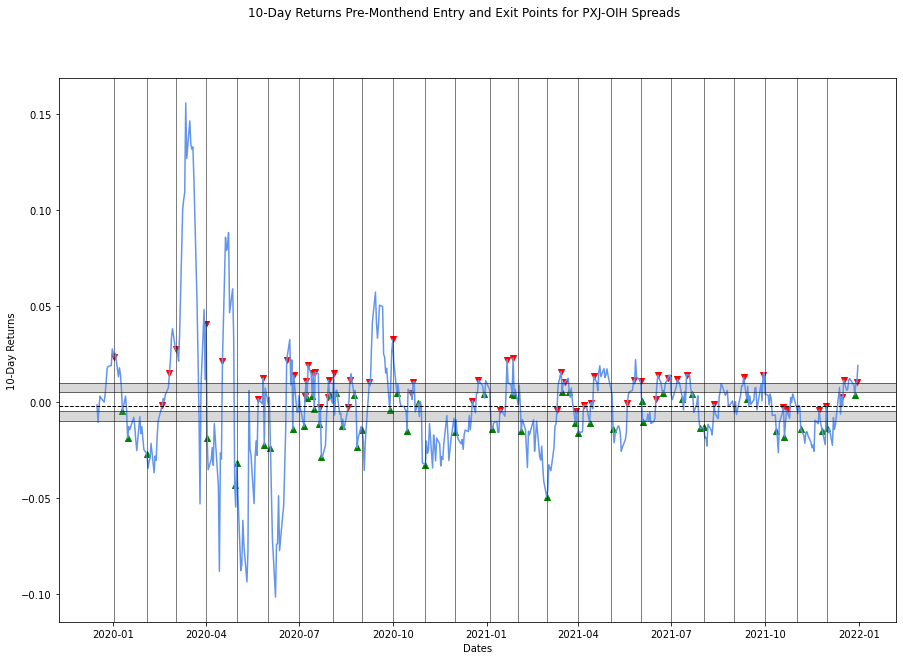

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
PL_DLY,0.8822,0.0000,-79.4369,-1.0003,1.7933,194.3473,16.8011,3.6308,39.5247,-20.5108,-26.7532,-33.3832,-33.7736
M_Day_Ret,-0.0023,-0.0025,-0.1018,-0.0159,0.0085,0.1556,0.0292,1.4003,7.5870,-0.0362,-0.0503,-0.0644,-0.0626


In [46]:
data_spread_2 = spread_strat(data_agg,myspread,10,0.01,0.005,0.8)
graph_spreads(data_spread_2, 10, 0.01, 0.005)
statistics(data_spread_2[['PL_DLY','M_Day_Ret']],0.05).T

##### 3. $M=21 \, , g=1.0\% \, , j=0.2\% \, , s = 80\%$

Cumulative PL for the strategy was $105.62, or 0.0000%


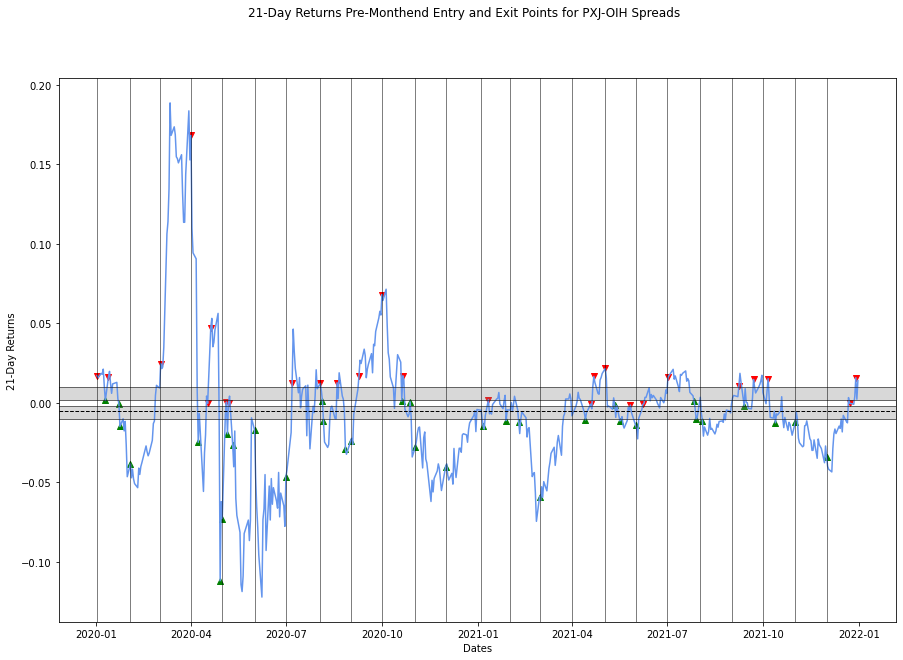

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
PL_DLY,0.2008,0.0000,-85.6360,-1.4860,2.9561,73.7312,14.7338,-0.8762,10.1625,-22.4041,-24.0342,-40.0670,-30.1908
M_Day_Ret,-0.0053,-0.0064,-0.1222,-0.0247,0.0073,0.1885,0.0420,1.5794,5.8494,-0.0622,-0.0743,-0.0825,-0.0919


In [85]:
data_spread_3 = spread_strat(data_agg,myspread,21,0.01,0.002,0.8)
graph_spreads(data_spread_3, 21, 0.01, 0.002)
statistics(data_spread_3[['PL_DLY','M_Day_Ret']],0.05).T

One interesting observation above is that when we bring g and j very close to zero, the returns appear to increase significantly. This is likely because of how tightly the returns hover around zero - the relationship appears to be stationary.

##### Optimization

This section will lay out various scenarios of M, g, j, and s. This will be achieved by iterating through the different scenarios.

For M, particularly meaningful inputs will be the daily, weekly, biweekly, triweekly, monthly, bimonthly, and quarterly periods (in business days). 

For g and j, according to the above examples, 50% of the percentage returns tend to be somewhere between -150 bps and 80 bps, though the change appears to be quite large depending on $M$. We will try setting g to 200bps to 60bps to cover these levels and see how the PL changes as we increment by 10bps. For j, we set the bound to be between zero and g.

For s, we will try setting with increments of 10%, bounded from 75% to 95%. We will assume that if our underlying positions fall in value by more than 25%, we will not continue the strategy - that is our maximum tolerance for loss. Anything above 90% can occur somewhat frequently, given the standard deviation of returns of the underliers average around 4%, and we want to allow for trading to continue for ~2 sigma moves. Stats in terms of returns of the underliers follow.

In [66]:
statistics(data_spread[['M_Day_Ret']],0.05).T

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
M_Day_Ret,-0.0011,-0.0011,-0.1141,-0.0103,0.0068,0.1589,0.0223,0.925,12.0951,-0.027,-0.0377,-0.0529,-0.047


In [67]:
Underliers = data_agg
Underliers = Underliers.assign(Spread_PXJ = np.log(data_agg['PXJ']/data_agg.shift()['PXJ']))
Underliers = Underliers.assign(Spread_OIH = np.log(data_agg['OIH']/data_agg.shift()['OIH']))
statistics(Underliers[['Spread_PXJ','Spread_OIH']],0.05).T

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
Spread_PXJ,-0.0006,-0.0011,-0.3221,-0.0196,0.0182,0.1491,0.0364,-1.2237,12.9945,-0.0525,-0.0604,-0.0833,-0.0756
Spread_OIH,-0.0004,-0.0007,-0.3893,-0.0200,0.0181,0.1734,0.0418,-1.3981,15.7962,-0.0579,-0.0691,-0.0978,-0.0866


Here, based on the assumptions above, iteration through the parameters is completed.

In [88]:
simulations                    = np.array([])
M_list, s_list, g_list, j_list = np.array([]),np.array([]),np.array([]),np.array([])
M_s                            = [5,10,15,21,42,63]

for i in M_s:
    s_s, g_s, j_s = 0.95, 0.01, 0
    while s_s >= 0.75:
        g_s, j_s  = 0.006, 0
        while g_s <= 0.02:
            j_s   = 0
            while g_s > j_s:
                g_list      = np.append(g_list, g_s)
                j_list      = np.append(j_list, j_s)
                s_list      = np.append(s_list, s_s)
                M_list      = np.append(M_list, i)
                simulations = np.append(simulations, simulate(data_agg,myspread,i,g_s,j_s,s_s))
                j_s += 0.001
            g_s += 0.001
        s_s -= 0.1

After running 3150 simulations based on the constraints described above, the below results are obtained. (I highlight in particular the top 10 and bottom 10 scenarios in terms of PL.)

Some prevalent patterns include:

For M, we can see that longer M_Day_Returns are better than shorter periods of time. In particular, the bi-monthly return seems to offer the optimal returns. Intuitively, we can ascertain that a signal based on too short a time frame on a volatile variable will result in blindly over-trading, leading to losses.

j = 0 is a clear loser - there should always be an inner band when making spread trades. The simulations favor an inner band of 110bps in 5 out of the top 10 cases.

g = 140bps is the leading parameter, but it looks like anything in the range of 120 to 160bps is reasonable.

s = 0.95 is consistent across the top ten simulations, while its levels are dispersed for the bottom 10. For optimal PL, it appears that tighter stop losses result in better cumulative PL.

In [287]:
np.set_printoptions(threshold=sys.maxsize,suppress=True,precision=3)
sim_results    = np.column_stack([simulations,g_list,j_list,s_list,M_list])
sim_results    = sim_results[np.argsort(sim_results[:, 0])]
sim_results_df = pd.DataFrame(sim_results,columns=['PL','g','j','s','M'])
print(pd.concat([sim_results_df.iloc[-15:,:],sim_results_df.iloc[:15,:]]).sort_values(by='PL',ascending=False).reset_index(drop=True))

              PL        g        j        s         M
0   1,142.655554 0.014000 0.011000 0.950000 42.000000
1   1,127.558698 0.013000 0.011000 0.950000 42.000000
2   1,123.581105 0.008000 0.001000 0.950000 42.000000
3   1,121.795443 0.016000 0.011000 0.950000 42.000000
4   1,119.499470 0.015000 0.011000 0.950000 42.000000
5   1,102.335793 0.014000 0.009000 0.950000 42.000000
6   1,099.436050 0.012000 0.011000 0.950000 42.000000
7   1,087.238937 0.013000 0.009000 0.950000 42.000000
8   1,082.372976 0.013000 0.012000 0.950000 42.000000
9   1,081.475682 0.016000 0.009000 0.950000 42.000000
10  1,081.270509 0.014000 0.008000 0.950000 42.000000
11  1,079.179709 0.015000 0.009000 0.950000 42.000000
12  1,078.234815 0.014000 0.010000 0.950000 42.000000
13  1,072.440300 0.006000 0.005000 0.950000 42.000000
14  1,068.982019 0.008000 0.003000 0.950000 42.000000
15 -1,075.045298 0.009000 0.001000 0.750000  5.000000
16 -1,089.162574 0.010000 0.000000 0.850000  5.000000
17 -1,134.564902 0.010000 0.

Based on these results, and given the top ten simulations have mostly similar levels for its parameters, it appears that there is a consistent and reliable strategy we can implement. The ending PL is not too different for the top 10 either - the PL are all within a range of \\$60.

For the deep-dive analysis, the first place simulation can be used with confidence - there is no large concern that it will not be representative of other well-performing simulations.

It's parameters are: $g = 1.4\% \, , j = 1.1\% \, , s = 0.95 \, , M = 42$.

Before starting the deep-dive, below is a summary of the returns and statistics of the optimal scenario.

Cumulative PL for the strategy was $1142.66, or 0.0002%


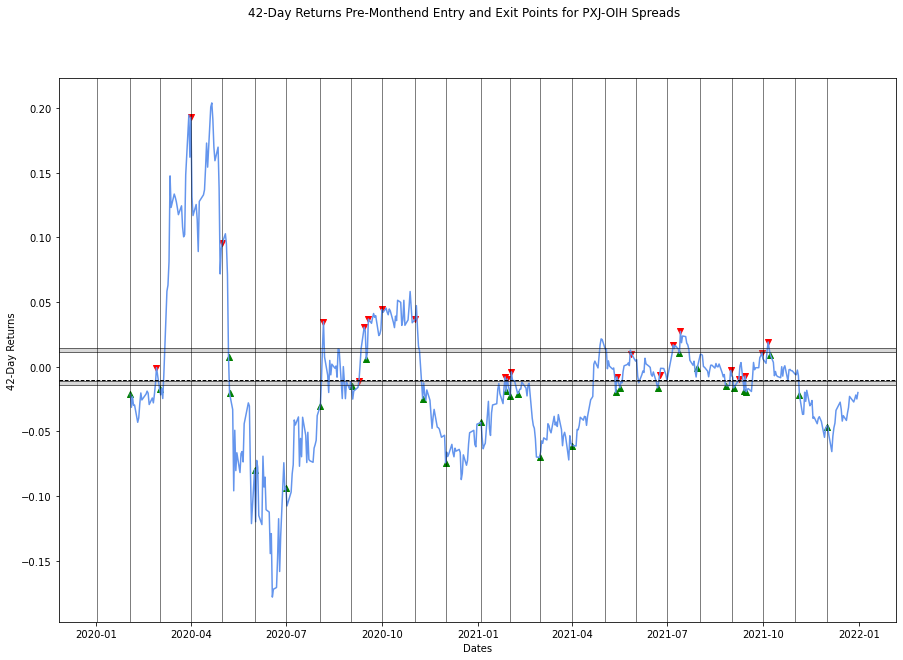

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
PL_DLY,2.172300,0.000000,-59.868100,0.000000,1.191500,265.715300,17.270200,7.846200,107.898200,-11.940000,-26.234600,-23.378500,-33.451100
M_Day_Ret,-0.010600,-0.013500,-0.178200,-0.044300,0.006000,0.203800,0.057800,1.009800,2.571300,-0.082300,-0.105700,-0.118900,-0.129800


In [116]:
data_spread_optimal = spread_strat(data_agg,myspread,42,0.014,0.011,0.95)
graph_spreads(data_spread_optimal, 42, 0.014, 0.011)
statistics(data_spread_optimal[['PL_DLY','M_Day_Ret']],0.05).T

#### Optimized Trading Strategy Deep-Dive

##### Strategy Assumptions and Effectiveness

As a sense check, a couple of statistical tests can be done to make sure that a spread trade is reasonable for the dataset. In particular, checking for stationarity is a key point.

This is followed by checking for seasonality, and seeing if any residuals are stationary.

The analysis below concludes that seasonality is a relatively small portion of the data - especially during the highly volatile Q120 and Q220. The 42 day returns are stationary, as well as the residuals following the seasonality check. This supports the fact that a spread trade is viable over extended periods of time.

In [260]:
print("Dataset: {}\nP-value: {:.2f}\nStationary?: {}".format('42 Day Returns',adfuller(data_spread_optimal.loc[:,'M_Day_Ret'].dropna())[1],"Yes" if adfuller(data_spread_optimal.loc[:,'M_Day_Ret'].dropna())[1] < 0.05 else "No"))

Dataset: 42 Day Returns
P-value: 0.03
Stationary?: Yes


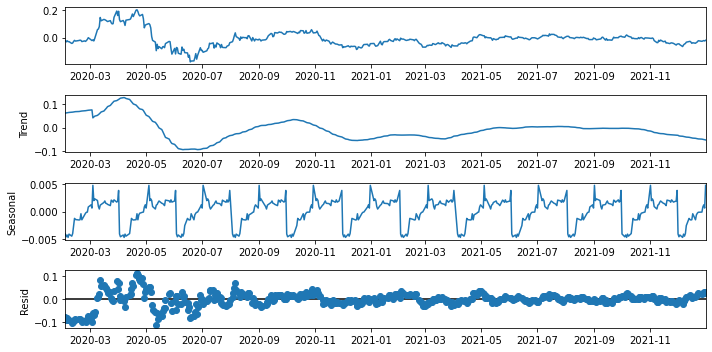

Residuals are stationary.
P-value=0.00


In [262]:
Spread_Strat= seasonal_decompose(data_spread_optimal.loc[:,['M_Day_Ret']].dropna(), model = 'additive',extrapolate_trend = 'freq', period = 42)
plt.rcParams['figure.figsize'] = [10,5]
Spread_Strat.plot()
plt.show()
print("Residuals are stationary.\nP-value={:.2f}".format(adfuller(Spread_Strat.resid.dropna())[1]) if adfuller(Spread_Strat.resid.dropna())[1] < 0.05 else "Residuals are non-stationary.")

##### Performance Metrics: Returns

The LTD return in percentages of the strategy is only 2bps, given how huge the capital was set for the strategy. Only \\$1k was made on \\$5M capital. I can make more money leaving cash in my Japanese bank account. Given how low these returns are, it would not make sense to proceed with any return performance metrics such as Sharpe/Treynor/Information/Sortino - this would only result in GIGO accounting.

In terms of outright daily PL, vol is more than 8 times the median $2 return, suggesting that the strategy isn't necessarily stable as well (This can be seen in the table above).

In [124]:
data_spread_optimal['Returns_LTD'][-1]

0.00021915775222936844

###### Return Moments: Skew and Kurtosis

The returns for this strategy are highly leptokurtic at 107.88, given the strategy doesn't have an open position most of the time, and the daily returns swing around the mean, at different levels of volatility throughout time. There is large positive skew as well, given that the strategy is set up to reap large rewards when the spread mean reverts, and stop losses at 95% of gross traded cash curb losses in opposite situations.

In [128]:
statistics(data_spread_optimal[['Returns_DLY']],0.05).T[['Skewness','Excess Kurtosis']]

,Skewness,Excess Kurtosis
Returns_DLY,7.845500,107.884600


##### Risk Metrics: VaR, Maximum Drawdown,and Largest Single-Period Drawdown

Analyzing further risk metrics in terms of returns has its limitations for the same reasons as above - the capital is too big to make any sense of the numbers.

If we analyze VaR and maximum drawdown in dollar terms, the losses seem to be quite large when compared to the mean/median of the strategy. On average we make \\$2 a day on the strategy, while 1 in 20 times we can lose more than \\$26 dollars (an average of \\$33). The maximum drawdown this strategy experienced was -\\$137 in May 2020, and it recovered by early September.

The single largest drawdown date was on April 7, 2021. The strategy had already started the month by signaling buys on the spread given the 42 day return of -6\% on the spread. The spread proceeded to rapidly converge, and the strategy made \\$180 over two days before bouncing back by -\\$59. Stop loss was not triggered through the selloff of both ETFs, until two days after the single largest drawdown date. The strategy made money on those two days as well. A table is provided for reference and details, following the visuals.

In [237]:
tail_risk_report(data_spread_optimal[['PL_DLY','Returns_DLY']],0.05,False).T

,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal),Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
PL_DLY,7.846170,107.898179,-11.940002,-26.234577,-23.378479,-33.451082,-137.527351,2020-05-13,2020-06-08,2020-09-08,-59.868116,2021-04-07,118
Returns_DLY,7.845545,107.884596,-0.000002,-0.000005,-0.000004,-0.000006,-0.000026,2020-05-13,2020-06-08,2020-09-08,-0.000011,2021-04-07,118


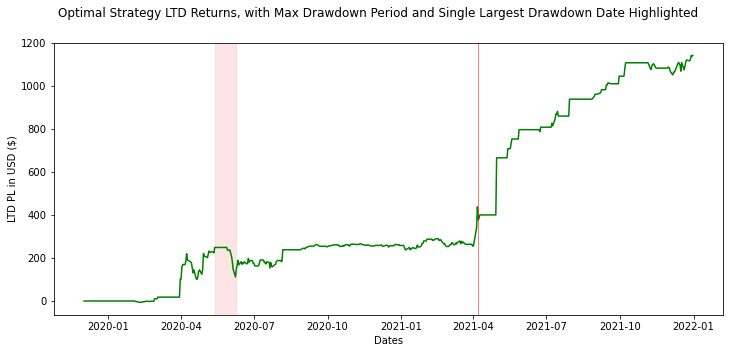

In [253]:
fig, ax1 = plt.subplots(figsize = (12,5))
fig.suptitle('Optimal Strategy LTD Returns, with Max Drawdown Period and Single Largest Drawdown Date Highlighted')
ax1.plot(data_spread_optimal[['PL_LTD']],'g')
plt.axvspan(['2020-05-13'], ['2020-06-08'], color='lightcoral', alpha=0.2)
plt.axvline(x=['2021-04-07'], color='red', linestyle='-',linewidth=0.5)
ax1.set_xlabel('Dates')
ax1.set_ylabel('LTD PL in USD ($)')
plt.show()

In [258]:
data_spread_optimal.loc['2021-04-01':'2021-04-09',:]

,OIH,PXJ,N_t,Capital,Spread,First,Last,M_Day_Ret,Signal,Position,X_Shares,Y_Shares,X_MV,Y_MV,GTCash,StopLossLevel,OpenGrossMV,StopLossTrigger,PL_DLY,PL_LTD,NetAssets,Mark,StopLossDay,Returns_DLY,Returns_LTD
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01,194.808950,3.415010,"1,645,694.252772","5,212,135.615478",-0.008563,True,False,-0.061036,Buy,1,"4,819.000000",84.000000,"16,456.931377","16,363.951807","32,820.883184","31,179.839025","32,820.883184",No,0.000000,255.503518,"5,212,391.118995",Buy,No,0.000000,0.000049
2021-04-05,189.790244,3.345316,"1,551,172.640690","5,212,135.615478",0.005481,False,False,-0.061345,Buy,1,"4,819.000000",84.000000,"16,121.075634","15,942.380488","32,820.883184","31,179.839025","32,063.456122",No,85.715577,341.219095,"5,212,476.834572",No,No,0.000016,0.000065
2021-04-06,188.067848,3.335359,"1,645,694.252772","5,212,135.615478",0.006136,False,False,-0.048592,Buy,1,"4,819.000000",84.000000,"16,073.096243","15,797.699207","32,820.883184","31,179.839025","31,870.795449",No,96.701889,437.920984,"5,212,573.536462",No,No,0.000019,0.000084
2021-04-07,188.780563,3.335359,"1,551,172.640690","5,212,135.615478",-0.003783,False,False,-0.048845,Buy,1,"4,819.000000",84.000000,"16,073.096243","15,857.567323","32,820.883184","31,179.839025","31,930.663565",No,-59.868116,378.052868,"5,212,513.668345",No,No,-0.000011,0.000073
2021-04-08,186.414743,3.295534,"1,373,454.245553","5,212,135.615478",0.000599,False,False,-0.045497,Buy,1,"4,819.000000",84.000000,"15,881.178675","15,658.838437","32,820.883184","31,179.839025","31,540.017112",No,6.811319,384.864187,"5,212,520.479665",No,No,0.000001,0.000074
2021-04-09,182.643290,3.233009,"1,308,571.501995","5,212,135.615478",0.001284,False,False,-0.039184,Buy,1,"4,819.000000",84.000000,"15,579.868095","15,342.036321","32,820.883184","31,179.839025","30,921.904416",Yes,15.491535,400.355722,"5,212,535.971200",No,Yes,0.000003,0.000077


##### Return Decomposition: Fama-French and Downside Beta

Generally speaking, it may be hard to observe significant correlation with factor data, just because of the fact that this strategy does not have a position open most of the time. The stop loss gets triggered relatively easily at 95%, and the bands are quite tight when looking at the graph and seeing the swings in the spread across time.

In terms of correlation, the relationship of the strategy across all factors are very low, but slightly negative. Given these results, we could consider this strategy immune to the market, and able to offer diversification benefits. The most relevant information we could draw from this correlation data is that there is a relatively high negative relationship with HML. This may suggest that our strategy can sometimes resemble returns of a growth stock - which may make sense given that these are energy ETFs - and commodities can at times move in tandem with the general trend of the equity market. However, the relationship is not even -0.1.

In [122]:
data_spread_optimal_ret = data_spread_optimal.loc[:'2021-11',['Returns_DLY']] * 100
pd.options.display.float_format = '{:,.6f}'.format
data_spread_FF_comp = pd.concat([data_spread_optimal_ret,FFFactors],axis=1)
data_spread_FF_comp.corr()

,Returns_DLY,Mkt-RF,SMB,HML,RF
Returns_DLY,1.000000,-0.025503,-0.010327,-0.075012,-0.025158
Mkt-RF,-0.025503,1.000000,0.137649,0.193948,-0.075146
SMB,-0.010327,0.137649,1.000000,0.208304,-0.052929
HML,-0.075012,0.193948,0.208304,1.000000,-0.080576
RF,-0.025158,-0.075146,-0.052929,-0.080576,1.000000


The R-Squared is extremely low when regressing the strategy returns against the Fama French factors, again suggesting that there is no relationship ( $R^2$ is not even 1\%.). When including an intercept, the alpha is very high as well at 0.01% annualized, suggesting again that there are no significant beta relationships here.

In [279]:
OLSIntercept(data_spread_optimal_ret,FFFactors)

(('Beta:',
  Mkt-RF   -0.000003
  SMB       0.000002
  HML      -0.000018
  RF       -0.004562
  dtype: float64),
 'Alpha (Ann): 0.01156 R-Squared: 0.00681 Tracking Error: 0.00525')

In [281]:
OLSNOIntercept(data_spread_optimal_ret,FFFactors)

(('Beta:',
  Mkt-RF   -0.000001
  SMB       0.000004
  HML      -0.000018
  RF        0.002809
  dtype: float64),
 'R-Squared: 0.00644 Tracking Error: 0.00525')

Finally, downside beta can be analyzed using the Fama French Market premium and risk free rate. Again, the returns on the strategy are so small that this is pretty much meaningless. The R-Squared is smaller than from the regressions against the Fama French factors, suggesting that there is no relationship with stressed markets and the spread strategy. This is likely because the spreads naturally create a long/short position, and the stop-loss is set at a high enough level that positions are exited before any unexpected adverse movements compound.

In [284]:
data_downside_beta = data_spread_FF_comp[data_spread_FF_comp['Mkt-RF'] + data_spread_FF_comp['RF']< 0]
data_downside_beta = data_downside_beta.assign(Market = data_downside_beta['Mkt-RF'] + data_downside_beta['RF'])
OLSIntercept(data_downside_beta['Returns_DLY'],data_downside_beta['Market'])

(('Beta:',
  Market   0.000001
  dtype: float64),
 'Alpha (Ann): 0.01619 R-Squared: 0.00001 Tracking Error: 0.00679')

In [285]:
OLSNOIntercept(data_downside_beta['Returns_DLY'],data_downside_beta['Market'])

(('Beta:',
  Market   -0.000019
  dtype: float64),
 'R-Squared: 0.00700 Tracking Error: 0.00681')

##### Foregone Analysis: Benchmarking and Stress Tests

Although both ETFs are related to the oil/energy industry, and the funds are different in terms of their allocations across large/mid/small caps, the correlations above show that there is no clear relationship between the spread strategy and the general market or factors. Benchmarking will be irrelevant given the unique nature of the strategy, so it would be better to focus on absolute returns as a risk measure. In order to do that however, capital allocation to the strategy will need to be reduced significantly.

With regards to stress tests, the data covers the COVID shock of 2020, through which the strategy still managed to hold a close to zero relationship with external factors. Given it is known that the strategy is unique and that the risk controls (stop-loss at 95\%) are robust, stress test analysis can be foregone. In the case that capital allocation to the strategy is significantly reduced, then stress tests can be implemented for hypothetical high negative/positive correlation scenarios, or backtesting in other periods such as Greek Bonds, Lehman, or LTCM.

### Conclusion

The analysis shows that for a mean-reversion spread strategy on the pair PXJ-OIH, two oil equities ETFs, it is optimal to enter a strategy that uses extended period returns and high stop-loss cutoffs. Specifically, the 3150 simulations that were run conclude that the parameters $g = 1.4\% \, , j = 1.1\% \, , s = 0.95 \, , M = 42$ provide the best results.

In order to make this strategy more powerful, capital allocated to the strategy should be decreased significantly, as the return metrics were close to useless - almost none of the capital was deployed - the maximum gross traded cash recorded for the optimal strategy was only \\$33k (see below), against \\$5m of capital.

Further analysis could be done with respect to returns at lower capital levels to see how performance can be enhanced.

In terms of Fama French factors, the strategy seems to be isolated from market movements and other traditional factors used for return decomposition, which means that the strategy would provide sufficient diversification benefits in a portfolio of strategies.

The risk metrics also show that the strategy is susceptible to surprise gains (positive skew), and the max drawdown was relatively small when compared to the cumulative PL.

This analytical approach should be transferable to other spread strategies - and additional analysis could be added provided more data and favorable conditions available - such as stress tests/benchmarking in the case that there is a stronger relationship with the market.

In [289]:
print("Max Gross Traded Cash: ${:.2f}".format(data_spread_optimal['GTCash'].max()))

Max Gross Traded Cash: $32820.88
